# how many empty scenes?
# how many objects with only one or two points?

In [ ]:
from time import time
from typing import Sequence
import matplotlib.pyplot as plt
import numpy as np    
from radar_scenes.coordinate_transformation import *
from radar_scenes.sequence import Sequence
import os


def get_timestamps(sequence: Sequence):
    '''
    Create the list of all timesteps
    '''
    timestamps = []
    for idx, scene in enumerate(sequence.scenes()):
        radar_data = scene.radar_data
        timestamps.append(radar_data[0][0]) 
    return timestamps
        

def get_current_scenes(sequence: Sequence, cur_idx, timestamps, n_prev_frames:int, n_next_frames: int): # what is timestamps?? 
    """
    Retrieves the scenes which should be displayed according to the current values of the time slider and the
    spinboxes for the past and future frames.
    Values of the spinboxes are retrieved and from the list of timestamps, the corresponding times are obtained.
    :return: The current frame (type Scene) and a list of other frames (type Scene) which should be displayed.
    """
    # cur_idx = timeline_slider.value()
    cur_timestamp = timestamps[cur_idx]
    current_scene = sequence.get_scene(cur_timestamp)
    other_scenes = []
    for i in range(1, n_prev_frames + 1):  # in the GUI, show previous frames/ show future frames!
        if cur_idx - i < 0:
            break
        t = timestamps[cur_idx - i]
        other_scenes.append(sequence.get_scene(t))
    for i in range(1, n_next_frames + 1):
        if cur_idx + i >= len(timestamps):
            break
        t = timestamps[cur_idx + i]
        other_scenes.append(sequence.get_scene(t))
    return current_scene, other_scenes


def trafo_radar_data_world_to_car(scene, other_scenes) -> np.ndarray:
    """
    Transforms the radar data listed in other_scenes into the same car coordinate system that is used in 'scene'.
    :param scene: Scene. Containing radar data and odometry information of one scene. The odometry information from
    this scene is used to transform the detections from the other timestamps into this scene.
    :param other_scenes: List of Scene items. All detections in these other scenes are transformed
    :return: A numpy array with all radar data from all scenes. The fields "x_cc" and "y_cc" are now relative to the
    current scene.
    """
    if len(other_scenes) == 0:
        return scene.radar_data
    other_radar_data = np.hstack([x.radar_data for x in other_scenes])
    x_cc, y_cc = transform_detections_sequence_to_car(other_radar_data["x_seq"], other_radar_data["y_seq"],
                                                        scene.odometry_data)
    other_radar_data["x_cc"] = x_cc
    other_radar_data["y_cc"] = y_cc
    return np.hstack([scene.radar_data, other_radar_data])


def get_frames(sequence: Sequence, cur_idx, timestamps, n_prev_frames=0 , n_next_frames=0):
    """
    Plot the current frames.
    :param: cur_idx: the frame number to be ploted
    :return: None
    """
    if len(timestamps) == 0 or cur_idx >= len(timestamps):
        return
    cur_timestamp = timestamps[cur_idx]
    current_scene, other_scenes = get_current_scenes(sequence, cur_idx, timestamps, n_prev_frames, n_next_frames)   # 4 sensors together
    radar_data = trafo_radar_data_world_to_car(current_scene, other_scenes) 
    return radar_data

def plot_frames(radar_data: list):
    # extract x, y from the list
    x = np.zeros(len(radar_data))
    y = np.zeros(len(radar_data))
    for idx, point in enumerate(radar_data): # radar_data is ndarray already, can be simplified here !
        x[idx] = point[7]
        y[idx] = point[8]
    col = [0, 0, 0, 1]
    plt.plot(
        y,
        x,
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3
    )
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_xaxis()
    plt.show()
    return

# statistic for the whole dataset

In [ ]:

path_to_dataset = "/home/s0001516/thesis/dataset/RadarScenes/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
nm_labeled_points = []
nm_instances = []
# iterate over all sequences
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        # iterate over all sensor scans
        for cur_idx in range(len(timestamps)):
            #m number of labeled points (not background)
            radar_data = get_frames(sequence, cur_idx, timestamps)
            labeled_idx = np.where(radar_data["label_id"] != 11)[0] # not static # other class's distribution can also be counted
            nm_labeled_points.append(len(labeled_idx))
            # number of instances
            track_ids = set(radar_data["track_id"])
            nm_instances.append(len(track_ids)-1)

print('Number of total sensor scans is {}'.format(len(nm_labeled_points)))

In [ ]:
print('Number of total sensor scans is {}'.format(len(nm_labeled_points)))
#print(nm_labeled_points)
#print(nm_instances)  # why no 0??

# Task 1: replot the histogram as Fig 4b

In [ ]:
# plot histogram
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(np.array(nm_labeled_points), bins=np.arange(1, 50, 5), facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("number of labeled points")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("labled points per scan")
plt.show()

how many sensor scan that has no labeled points?

In [ ]:
a = sum(np.array(nm_labeled_points)==0)
b = sum(np.array(nm_labeled_points)==1)
print('There are {} / {} scan with no labeled points \n {}'.format(a, len(nm_labeled_points), a/len(nm_labeled_points)))

Looks quite close to 4 b)

In [ ]:
# 
y1 = sum(np.array(nm_instances) == 1)
y2 = sum(np.array(nm_instances) == 2)
y3 = sum(np.array(nm_instances) == 3)
y4 = sum(np.array(nm_instances) == 4)
print(y1)
print(y2)
print(y3)
print(y4)
x = range(1, np.max(nm_instances))
y = []
for i in x:
    y.append(sum(np.array(nm_instances) == i))

In [ ]:

plt.bar(x, y)
# 显示横轴标签
plt.xlabel("number of instances")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("instances per scan")
plt.show()


In [ ]:
print(sum(y)) # totoal number of instances

In [ ]:
# try with a frame

# extract a frame, i.e., 4 continuous scenes from the start time, for DBSCAN
path_to_dataset = "/home/s0001516/thesis/dataset/RadarScenes/"
# Define the *.json file from which data should be loaded
filename = os.path.join(path_to_dataset, "data", "sequence_137", "scenes.json")
sequence = Sequence.from_json(filename)
timestamps = get_timestamps(sequence)
cur_idx = 0
radar_data = get_frames(sequence, cur_idx, timestamps)

# print(radar_data['track_id'])
# print(type(radar_data)) # a lot of empty frames
plot_frames(radar_data)

In [ ]:
print(np.array([radar_data['x_cc'], radar_data['y_cc']]).shape)

/tmp/ipykernel_5584/742757815.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


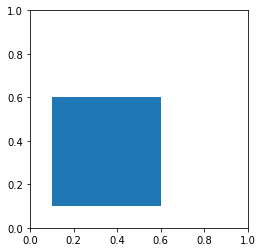

In [ ]:
|